In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

In [63]:
# Load pre-trained models and scalers
# try:
#     model_si = joblib.load('model_si.pkl')
#     model_tandem_top = joblib.load('model_tandem_top.pkl')
#     model_tandem_bot = joblib.load('model_tandem_bot.pkl')
#     scaler_si = joblib.load('scaler_si.pkl')
#     scaler_tandem = joblib.load('scaler_tandem.pkl')
#     print("✅ Models loaded successfully!")
# except:
#     print("❌ Could not load models. Please ensure model files exist.")
#     # Create dummy models for demonstration
#     model_si = RandomForestRegressor()
#     model_tandem_top = RandomForestRegressor()
#     model_tandem_bot = RandomForestRegressor()
#     scaler_si = StandardScaler()
#     scaler_tandem = StandardScaler()

model_si = joblib.load('/content/model_si.pkl')
model_tandem_top = joblib.load('/content/model_tandem_top.pkl')
model_tandem_bot = joblib.load('/content/model_tandem_bot.pkl')
scaler_si = joblib.load('/content/scaler_si.pkl')
scaler_tandem = joblib.load('/content/scaler_tandem.pkl')
print("✅ Models loaded successfully!")

✅ Models loaded successfully!


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import warnings

def create_pointillism_image(image_path, opacity_level):
    """Create pointillism image with specified opacity level using concentric circles"""

    # Parameters for fast processing
    coverage_pct = opacity_level
    frame_width_mm = 400
    frame_height_mm = 400
    px_per_mm = 10

    # Try different configurations based on opacity level
    if opacity_level <= 0.3:
        # Low opacity - use small dots
        outer_diameters = [1.2]
    elif opacity_level <= 0.6:
        # Medium opacity - medium dots
        outer_diameters = [1.6]
    else:
        # High opacity - larger dots with reduced coverage to avoid math errors
        outer_diameters = [2.0]
        coverage_pct = min(opacity_level, 0.75)  # Cap high opacities

    max_attempts = 2
    for attempt in range(max_attempts):
        try:
            CircleObj = ConcentricCircles(
                outer_Ds_mm=outer_diameters,
                count=1,
                coverage_pct=coverage_pct,
                square_width_mm=2,
                px_per_mm=px_per_mm
            )
            break
        except ValueError as e:
            if attempt == max_attempts - 1:
                # Last attempt failed, use a very simple configuration
                print(f"Warning: Using fallback configuration for opacity {opacity_level:.3f}")
                CircleObj = ConcentricCircles(
                    outer_Ds_mm=[1.5],
                    count=1,
                    coverage_pct=0.5,  # Fixed safe coverage
                    square_width_mm=2,
                    px_per_mm=px_per_mm
                )
            else:
                # Try with reduced coverage
                coverage_pct *= 0.9  # Reduce coverage by 10%
                outer_diameters[0] *= 1.1  # Increase diameter slightly

    # Create processor
    processor = Pointillizer(
        image_path=image_path,
        output_path="",
        CircleObj=CircleObj,
        frame_width_mm=frame_width_mm,
        frame_height_mm=frame_height_mm,
        px_per_mm=px_per_mm,
    )

    # Process image
    processor.load_and_resize_image()
    img = processor.process_and_draw(saving=False)

    # Remove native color
    native_color = (0, 0, 0)
    img = replaceColor(img, native_color, saveName=None, radius=30)

    return np.array(img)

# Keep all the helper classes and functions as they are, but remove the file saving parts
class ConcentricCircles:
    def __init__(self, outer_Ds_mm, inner_Ds_mm=None, count=None, thickness_mm=None,
                 coverage_pct=None, has_inner_circle=False, square_width_mm=2,
                 px_per_mm=12, null_color=(0, 0, 0, 0)):
        # Sorts in descending order
        self.outer_Ds_mm = np.sort(castArray(outer_Ds_mm))[::-1]

        if not inner_Ds_mm is None:
            self.inner_Ds_mm = np.sort(castArray(inner_Ds_mm))[::-1]
        else:
            self.inner_Ds_mm = None

        self.square_width_mm = square_width_mm
        self.px_per_mm = px_per_mm
        self.null_color = null_color

        if coverage_pct is None:
            self._init_no_area(count, thickness_mm, has_inner_circle)
        else:
            self._init_area(count, coverage_pct, has_inner_circle)

    def _init_no_area(self, count, thickness_mm, has_inner_circle):
        if not self.inner_Ds_mm is None:
            return
        if not count is None:
            if len(self.outer_Ds_mm) > 1:
                warnings.warn(f"Supplying both a count ({count}) and multiple outer diameters ({self.outer_Ds_mm}) is redundant. The extra outer diameters will be discarded")
            outerD = self.outer_Ds_mm[0]
            spacing = 2*outerD/(count*2-has_inner_circle)
            if thickness_mm is None:
                thickness_mm = spacing/4
            self.outer_Ds_mm = np.array([outerD - i * spacing for i in range(count)])
        if thickness_mm is None:
            raise ValueError("Must supply at least one of the following: thickness, count, or area")
        self.inner_Ds_mm = self.outer_Ds_mm - thickness_mm*2
        checkArray = np.zeros(len(self.inner_Ds_mm))
        checkArray[:-1] = self.outer_Ds_mm[1:]
        if (self.inner_Ds_mm < checkArray).any():
            raise ValueError(f"Inner diameter circles overlap or are negative:\nInner: {self.inner_Ds_mm}\nOuter: {self.outer_Ds_mm}")
        return

    def _init_area(self, count, coverage_pct, has_inner_circle):
        if count is None:
            count = len(self.outer_Ds_mm)
        area_mm2 = self.square_width_mm**2*coverage_pct
        if has_inner_circle:
            self.outer_Ds_mm, self.inner_Ds_mm = solveInnerCircle(self.outer_Ds_mm[0], area_mm2, count)
            return
        if count != len(self.outer_Ds_mm):
            outerD = self.outer_Ds_mm[0]
            full_thickness_mm = outerD/count
            self.outer_Ds_mm = np.array([outerD - i * full_thickness_mm for i in range(count)])
        thickness = solveThickness(self.outer_Ds_mm, area_mm2)
        self.inner_Ds_mm = self.outer_Ds_mm-2*thickness

    def drawCircles(self, draw, x_center, y_center, color):
        for i in range(len(self.outer_Ds_mm)):
            d = self.outer_Ds_mm[i]*self.px_per_mm
            bbox = (np.ceil(x_center - d/2), np.ceil(y_center - d/2), np.floor(x_center + d/2), np.floor(y_center + d/2))
            draw.ellipse(bbox, fill=color)
            if i < len(self.inner_Ds_mm):
                d = self.inner_Ds_mm[i]*self.px_per_mm
                bbox = (np.ceil(x_center - d/2), np.ceil(y_center - d/2), np.floor(x_center + d/2), np.floor(y_center + d/2))
                draw.ellipse(bbox, fill=self.null_color)

class Pointillizer:
    def __init__(self, image_path, output_path, CircleObj, frame_width_mm=400, frame_height_mm=400,
                 px_per_mm=12, cropping=True, background_color=None):
        self.image_path = image_path
        self.output_path = output_path
        self.frame_width_mm = frame_width_mm
        self.frame_height_mm = frame_height_mm
        self.px_per_mm = px_per_mm
        self.CircleObj = CircleObj
        self.CircleObj.px_per_mm = self.px_per_mm
        self.square_width_mm = self.CircleObj.square_width_mm
        if not background_color is None:
            self.CircleObj.null_color = background_color
        self.background = background_color if not background_color is None else (0, 0, 0, 0)
        self.cell_px = int(self.square_width_mm * self.px_per_mm)
        self.num_cols = self.frame_width_mm // self.square_width_mm
        self.num_rows = self.frame_height_mm // self.square_width_mm
        self.img_array = None
        self.processed_image = None
        self.cropping = cropping

    def _cropImg(self, img):
        horiginal, woriginal = np.array(img).shape[:-1]
        aspectRatio = woriginal/horiginal
        desiredAR = self.frame_width_mm/self.frame_height_mm
        if desiredAR > aspectRatio:
            yMiddle = horiginal/2
            offset = 0.5*woriginal/desiredAR
            newDimensions = (0, yMiddle-offset, woriginal, yMiddle+offset)
        else:
            xMiddle = woriginal/2
            offset = 0.5*horiginal*desiredAR
            newDimensions = (xMiddle-offset, 0, xMiddle+offset, horiginal)
        return img.crop(newDimensions)

    def load_and_resize_image(self):
        img = Image.open(self.image_path).convert('RGB')
        # Resize to match frame dimensions for speed
        target_size = (
            int(self.frame_width_mm * self.px_per_mm),
            int(self.frame_height_mm * self.px_per_mm)
        )
        img = self._cropImg(img)
        img = img.resize(target_size)
        self.processed_image = img.convert("RGBA")
        self.img_array = np.array(self.processed_image)

    def process_and_draw(self, saving=False):  # Changed default to False
        width_px = int(self.frame_width_mm*self.px_per_mm)
        height_px = int(self.frame_height_mm*self.px_per_mm)
        new_img = Image.new('RGBA', (width_px, height_px), self.background)
        draw = ImageDraw.Draw(new_img)

        for i in range(int(self.num_rows)):
            for j in range(int(self.num_cols)):
                x0 = j * self.cell_px
                y0 = i * self.cell_px
                cell_patch = self.img_array[y0:y0 + self.cell_px, x0:x0 + self.cell_px, :3]
                if cell_patch.shape[0] < self.cell_px or cell_patch.shape[1] < self.cell_px:
                    continue
                mean_color = np.mean(cell_patch.reshape(-1, 3), axis=0).astype('uint8')
                r, g, b = mean_color
                cx_px = int(j * self.cell_px + self.cell_px / 2)
                cy_px = int(i * self.cell_px + self.cell_px / 2)
                self.CircleObj.drawCircles(draw, cx_px, cy_px, (r, g, b))

        return new_img

def castArray(var):
    if isinstance(var, (list, tuple, np.ndarray)):
        return np.array(var)
    else:
        return np.array([var])

def solveThickness(outer_Ds_mm, area_mm2):
    outer_Rs = outer_Ds_mm/2
    a = -1*len(outer_Rs)*np.pi
    b = 2*np.pi*np.sum(outer_Rs)
    c = -1*area_mm2
    radical = b**2 - 4*a*c
    if radical < 0:
        raise ValueError("No solutions for the desired area. Make the outer diameters larger and more spaced apart")
    thickness = (-1*b+np.sqrt(radical))/(2*a)
    maxThicknesses = np.zeros(len(outer_Rs))
    maxThicknesses[:-1] = outer_Rs[1:]
    maxThicknesses = outer_Rs - maxThicknesses
    if np.min(maxThicknesses) < thickness:
        raise ValueError("The area solution produces a thickness that overlaps with other rings. Make the outer diameters larger or more uniformly spaced")
    return thickness

def solveInnerCircle(outer_D_mm, area_mm2, count):
    if count == 1:
        outer_Rs_mm = np.array([np.sqrt(area_mm2/np.pi)])
        inner_Rs_mm = np.zeros(0)
        return outer_Rs_mm*2, inner_Rs_mm*2
    outerR_mm = outer_D_mm/2
    thickness_mm = area_mm2/(np.pi*outerR_mm*count)
    cutout_thickness_mm = (outerR_mm-count*thickness_mm)/(count-1)
    outer_Rs_mm = np.array([outerR_mm - i*(thickness_mm+cutout_thickness_mm) for i in range(0, count)])
    inner_Rs_mm = outer_Rs_mm[:-1]-thickness_mm
    if True in outer_Rs_mm[1:] > inner_Rs_mm:
        raise ValueError("The area solution produces overlaping ring. Make the count or area smaller or the outer diameter larger")
    return outer_Rs_mm*2, inner_Rs_mm*2

def replaceColor(img, originalColor, newColor=None, saveName=None, radius=10):
    originalColor = np.array(originalColor)
    pixels = np.array(img)
    pixelDiff = pixels[:, :, :3] - np.array(originalColor[:3])
    pixelDist = np.max(pixelDiff, axis=2)
    withinR = pixelDist <= radius

    if newColor is None:
        pixels[:, :, 3] = pixels[:, :, 3]*np.logical_not(withinR)
    else:
        withinR = np.repeat(withinR[:, :, np.newaxis], 4, axis=2)
        newColorPixels = np.ones(pixels.shape)
        if len(newColor) == 3:
            newColorPixels[:, :, 3] = 255
            newColorPixels[:, :, :3] = newColorPixels[:, :, :3]*newColor
        else:
            newColorPixels = newColorPixels*newColor
        pixels = pixels*np.logical_not(withinR) + newColorPixels*withinR

    return Image.fromarray(pixels.astype('uint8'), mode='RGBA')

In [65]:
def predict_current_from_array(image_array, model_type="si"):
    """Predict current density from image array"""
    # Convert array to PIL Image and then to RGBA
    img = Image.fromarray(image_array).convert("RGBA")
    img_array = np.array(img)
    h, w, _ = img_array.shape

    # Reshape into (n_pixels, 4)
    pixels = img_array.reshape(-1, 4)
    pixel_df = pd.DataFrame(pixels, columns=['R', 'G', 'B', 'A'])

    # Predict
    if model_type.lower() == "si":
        X_scaled = scaler_si.transform(pixel_df)
        jph_preds = model_si.predict(X_scaled)
        return np.mean(jph_preds)

    elif model_type.lower() == "tandem":
        X_scaled = scaler_tandem.transform(pixel_df)
        jph_top = model_tandem_top.predict(X_scaled)
        jph_bot = model_tandem_bot.predict(X_scaled)
        jph_limiting = np.minimum(jph_top, jph_bot)
        return np.mean(jph_limiting)

    else:
        raise ValueError("Invalid model_type. Use 'si' or 'tandem'.")

In [66]:
def evolutionary_algorithm_optimization(image_path, model_type="si", generations=10, population_size=8):
    """Evolutionary Algorithm to find optimal opacity level"""
    print("🚀 Starting Evolutionary Algorithm for opacity optimization...")

    # Initialize population
    population = np.random.uniform(0.1, 0.9, population_size)
    best_opacity = 0.5
    best_current = 0

    # Store results for analysis
    results = []

    for generation in range(generations):
        print(f"\nGeneration {generation + 1}/{generations}")
        generation_results = []

        for i, opacity in enumerate(population):
            try:
                # Create pointillism image with current opacity
                pointillism_img = create_pointillism_image(image_path, opacity)

                # Predict current
                current = predict_current_from_array(pointillism_img, model_type)
                generation_results.append((opacity, current))

                print(f"  Individual {i+1}: opacity={opacity:.3f}, current={current:.3f} mA/cm²")

                # Update best solution
                if current > best_current:
                    best_current = current
                    best_opacity = opacity

            except Exception as e:
                print(f"  Error with opacity {opacity}: {e}")
                generation_results.append((opacity, 0))

        results.extend(generation_results)

        # Selection: Keep best individuals
        generation_results.sort(key=lambda x: x[1], reverse=True)
        best_individuals = generation_results[:population_size//2]

        # Crossover and Mutation
        new_population = [ind[0] for ind in best_individuals]  # Elitism

        while len(new_population) < population_size:
            # Select parents from best individuals
            parent1, parent2 = np.random.choice([ind[0] for ind in best_individuals], 2, replace=False)

            # Crossover (average)
            child = (parent1 + parent2) / 2

            # Mutation
            mutation = np.random.normal(0, 0.1)
            child = np.clip(child + mutation, 0.1, 0.9)

            new_population.append(child)

        population = np.array(new_population)

    # Find opacity with 20% loss from max current
    target_current = best_current * 0.8
    optimal_opacity = best_opacity
    min_diff = float('inf')

    for opacity, current in results:
        diff = abs(current - target_current)
        if diff < min_diff and current >= target_current:
            min_diff = diff
            optimal_opacity = opacity

    print(f"\n🎯 Optimization Complete!")
    print(f"Best opacity: {best_opacity:.3f} (Current: {best_current:.3f} mA/cm²)")
    print(f"Optimal opacity with 20% loss: {optimal_opacity:.3f}")
    print(f"Target current: {target_current:.3f} mA/cm²")

    return optimal_opacity, best_current, results

In [67]:
def split_image_into_cells(image_array, n_cells):
    """Split image into n x n grid of solar cells"""
    h, w, _ = image_array.shape

    # Calculate grid dimensions
    cells_per_side = int(np.sqrt(n_cells))
    if cells_per_side ** 2 != n_cells:
        print(f"⚠️ Warning: {n_cells} is not a perfect square. Using {cells_per_side**2} cells instead.")
        n_cells = cells_per_side ** 2

    cell_height = h // cells_per_side
    cell_width = w // cells_per_side

    cells = []
    positions = []

    for i in range(cells_per_side):
        for j in range(cells_per_side):
            y_start = i * cell_height
            y_end = (i + 1) * cell_height
            x_start = j * cell_width
            x_end = (j + 1) * cell_width

            cell = image_array[y_start:y_end, x_start:x_end]
            cells.append(cell)
            positions.append((i, j))

    return cells, positions, cells_per_side

In [68]:
def analyze_solar_cells(image_path, optimal_opacity, n_cells, model_type="si"):
    """Analyze current density for each solar cell"""
    print(f"\n🔬 Analyzing {n_cells} solar cells with opacity {optimal_opacity:.3f}...")

    # Create pointillism image with optimal opacity
    pointillism_img = create_pointillism_image(image_path, optimal_opacity)

    # Split into cells
    cells, positions, grid_size = split_image_into_cells(pointillism_img, n_cells)

    # Calculate current density for each cell
    cell_currents = []
    for i, cell in enumerate(cells):
        current = predict_current_from_array(cell, model_type)
        cell_currents.append(current)
        print(f"  Cell {i+1} (row {positions[i][0]}, col {positions[i][1]}): {current:.3f} mA/cm²")

    # Create current density matrix
    current_matrix = np.zeros((grid_size, grid_size))
    for (row, col), current in zip(positions, cell_currents):
        current_matrix[row, col] = current

    return cell_currents, current_matrix, grid_size, pointillism_img, positions  # Added positions to return

In [69]:
def equalize_currents(cell_currents, method="lowest"):
    """Equalize currents to match the specified method"""
    if method == "lowest":
        target_current = min(cell_currents)
    elif method == "average":
        target_current = np.mean(cell_currents)
    else:
        raise ValueError("Method must be 'lowest' or 'average'")

    equalized_currents = [target_current] * len(cell_currents)

    print(f"\n⚡ Current equalization ({method} method):")
    print(f"Target current: {target_current:.3f} mA/cm²")
    print(f"Original current range: {min(cell_currents):.3f} - {max(cell_currents):.3f} mA/cm²")
    print(f"Equalized all cells to: {target_current:.3f} mA/cm²")

    return equalized_currents, target_current

=== Solar Cell Current Density Analysis ===
Image: CJ.png
Model: si
Number of cells: 9

🚀 Starting Evolutionary Algorithm for opacity optimization...

Generation 1/8
  Individual 1: opacity=0.447, current=17.733 mA/cm²
  Individual 2: opacity=0.218, current=23.106 mA/cm²
  Individual 3: opacity=0.693, current=12.010 mA/cm²
  Individual 4: opacity=0.463, current=17.733 mA/cm²
  Individual 5: opacity=0.170, current=24.040 mA/cm²
  Individual 6: opacity=0.180, current=24.040 mA/cm²

Generation 2/8
  Individual 1: opacity=0.170, current=24.040 mA/cm²
  Individual 2: opacity=0.180, current=24.040 mA/cm²
  Individual 3: opacity=0.218, current=23.106 mA/cm²
  Individual 4: opacity=0.100, current=25.442 mA/cm²
  Individual 5: opacity=0.316, current=20.069 mA/cm²
  Individual 6: opacity=0.141, current=25.442 mA/cm²

Generation 3/8
  Individual 1: opacity=0.100, current=25.442 mA/cm²
  Individual 2: opacity=0.141, current=25.442 mA/cm²
  Individual 3: opacity=0.170, current=24.040 mA/cm²
  Indiv

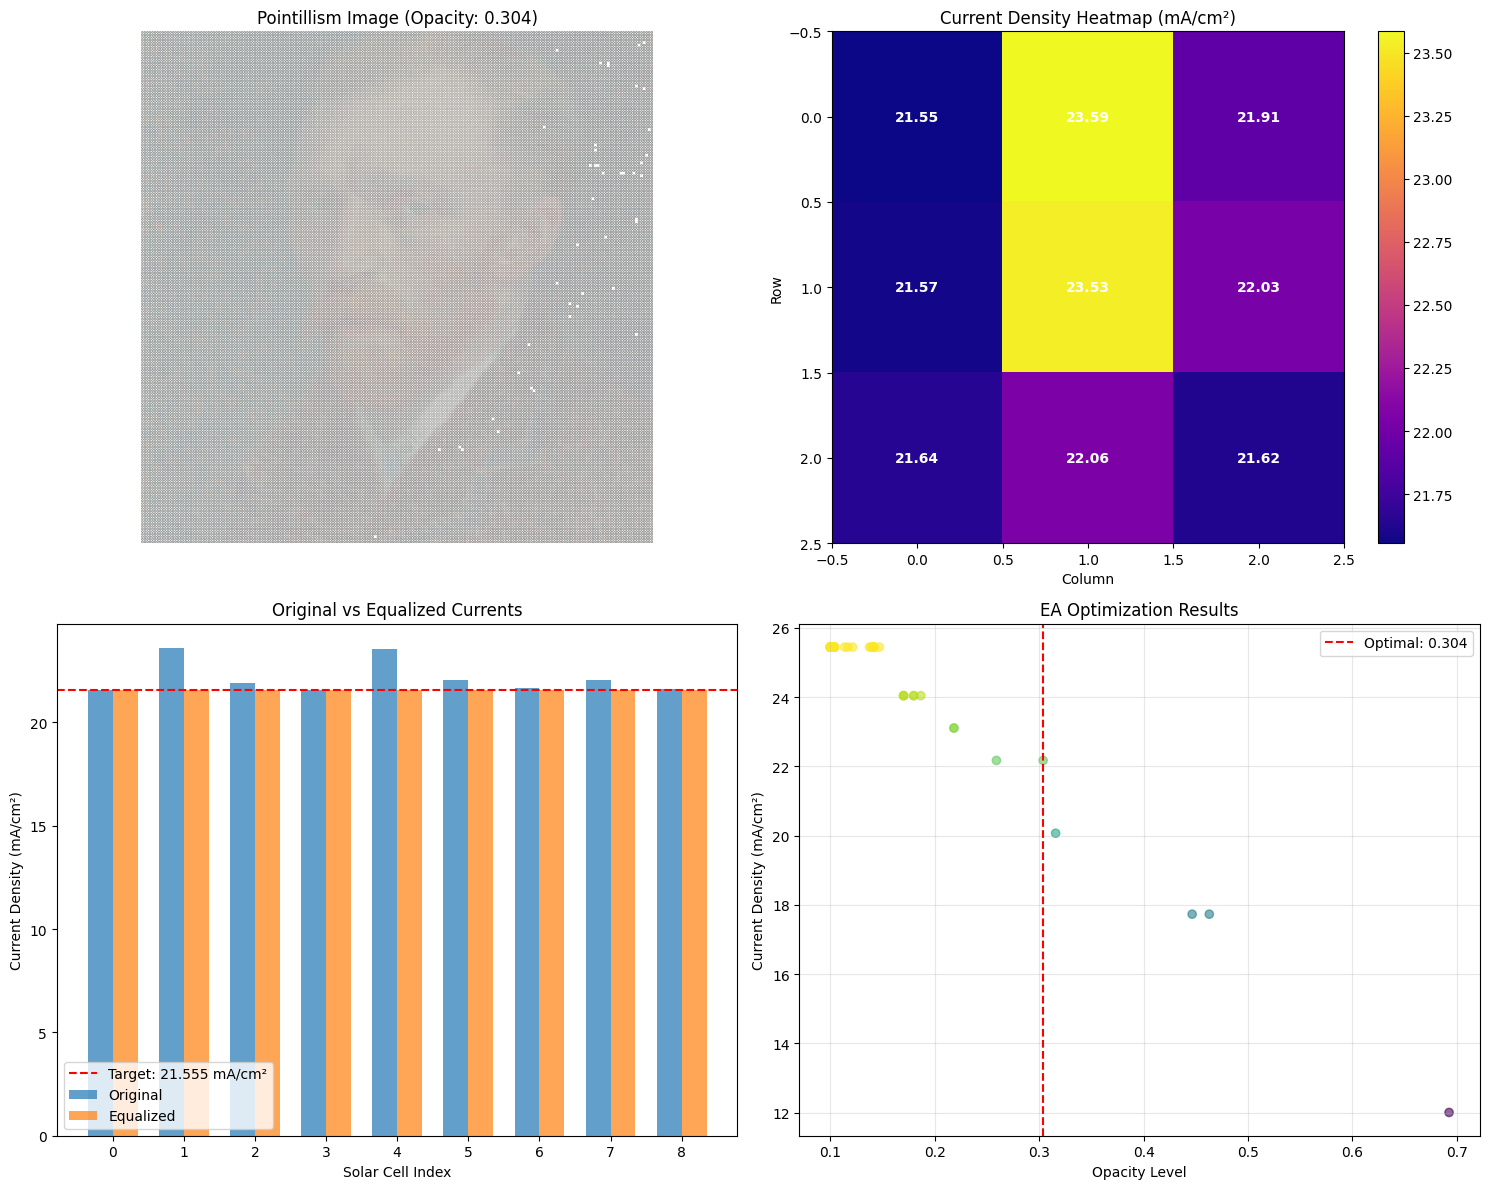


📈 SUMMARY STATISTICS
Optimal opacity level: 0.304
Maximum current density: 25.442 mA/cm²
Target current (20% loss): 20.353 mA/cm²
Number of solar cells: 9
Grid configuration: 3 × 3
Original current statistics:
  - Mean: 22.168 mA/cm²
  - Std: 0.765 mA/cm²
  - Min: 21.555 mA/cm²
  - Max: 23.585 mA/cm²
Equalized current: 21.555 mA/cm²

💾 Results saved to 'solar_cell_analysis_results.csv'


In [70]:
# Main execution
if __name__ == "__main__":
    # Configuration
    IMAGE_PATH = "CJ.png"  # Replace with your image path
    MODEL_TYPE = "si"  # "si" or "tandem"
    N_CELLS = 9  # Number of solar cells (should be perfect square: 4, 9, 16, 25, etc.)

    print("=== Solar Cell Current Density Analysis ===")
    print(f"Image: {IMAGE_PATH}")
    print(f"Model: {MODEL_TYPE}")
    print(f"Number of cells: {N_CELLS}")

    # Step 1: Find optimal opacity using Evolutionary Algorithm
    print("\n" + "="*50)
    optimal_opacity, max_current, ea_results = evolutionary_algorithm_optimization(
        IMAGE_PATH, MODEL_TYPE, generations=8, population_size=6
    )

    # Step 2: Split image into solar cells and analyze current densities
    print("\n" + "="*50)
    cell_currents, current_matrix, grid_size, processed_img, positions = analyze_solar_cells(
        IMAGE_PATH, optimal_opacity, N_CELLS, MODEL_TYPE
    )

    # Step 3: Equalize currents to match the lowest cell
    print("\n" + "="*50)
    equalized_currents, target_current = equalize_currents(cell_currents, method="lowest")

    # Visualization
    print("\n" + "="*50)
    print("📊 Generating visualizations...")

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Original pointillism image
    axes[0, 0].imshow(processed_img)
    axes[0, 0].set_title(f'Pointillism Image (Opacity: {optimal_opacity:.3f})')
    axes[0, 0].axis('off')

    # Plot 2: Current density heatmap
    im = axes[0, 1].imshow(current_matrix, cmap='plasma', aspect='equal')
    axes[0, 1].set_title('Current Density Heatmap (mA/cm²)')
    axes[0, 1].set_xlabel('Column')
    axes[0, 1].set_ylabel('Row')

    # Add values to heatmap
    for i in range(grid_size):
        for j in range(grid_size):
            axes[0, 1].text(j, i, f'{current_matrix[i, j]:.2f}',
                           ha='center', va='center', color='white', fontweight='bold')

    plt.colorbar(im, ax=axes[0, 1])

    # Plot 3: Original vs Equalized currents
    x_pos = np.arange(len(cell_currents))
    width = 0.35

    axes[1, 0].bar(x_pos - width/2, cell_currents, width, label='Original', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, equalized_currents, width, label='Equalized', alpha=0.7)
    axes[1, 0].axhline(y=target_current, color='r', linestyle='--', label=f'Target: {target_current:.3f} mA/cm²')
    axes[1, 0].set_xlabel('Solar Cell Index')
    axes[1, 0].set_ylabel('Current Density (mA/cm²)')
    axes[1, 0].set_title('Original vs Equalized Currents')
    axes[1, 0].legend()
    axes[1, 0].set_xticks(x_pos)

    # Plot 4: EA optimization progress
    opacities, currents = zip(*ea_results)
    axes[1, 1].scatter(opacities, currents, alpha=0.6, c=currents, cmap='viridis')
    axes[1, 1].axvline(x=optimal_opacity, color='red', linestyle='--', label=f'Optimal: {optimal_opacity:.3f}')
    axes[1, 1].set_xlabel('Opacity Level')
    axes[1, 1].set_ylabel('Current Density (mA/cm²)')
    axes[1, 1].set_title('EA Optimization Results')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "="*50)
    print("📈 SUMMARY STATISTICS")
    print(f"Optimal opacity level: {optimal_opacity:.3f}")
    print(f"Maximum current density: {max_current:.3f} mA/cm²")
    print(f"Target current (20% loss): {max_current * 0.8:.3f} mA/cm²")
    print(f"Number of solar cells: {N_CELLS}")
    print(f"Grid configuration: {grid_size} × {grid_size}")
    print(f"Original current statistics:")
    print(f"  - Mean: {np.mean(cell_currents):.3f} mA/cm²")
    print(f"  - Std: {np.std(cell_currents):.3f} mA/cm²")
    print(f"  - Min: {np.min(cell_currents):.3f} mA/cm²")
    print(f"  - Max: {np.max(cell_currents):.3f} mA/cm²")
    print(f"Equalized current: {target_current:.3f} mA/cm²")

    # Save results - NOW positions is defined
    results_df = pd.DataFrame({
        'Cell_Index': range(1, len(cell_currents) + 1),
        'Row': [pos[0] for pos in positions],
        'Column': [pos[1] for pos in positions],
        'Original_Current': cell_currents,
        'Equalized_Current': equalized_currents
    })

    results_df.to_csv('solar_cell_analysis_results.csv', index=False)
    print(f"\n💾 Results saved to 'solar_cell_analysis_results.csv'")

In [71]:
# Save the final optimized pointillism image
final_opacity = optimal_opacity  # From EA optimization
final_pointillism_img = create_pointillism_image(IMAGE_PATH, final_opacity)

# Save with meaningful filename
final_output_file = f"optimized_pointillism_opacity_{final_opacity:.3f}.png"
plt.figure(figsize=(12, 12))
plt.imshow(final_pointillism_img)
plt.axis('off')
plt.savefig(final_output_file, dpi=300, bbox_inches='tight', pad_inches=0,
            facecolor='none', transparent=True)
plt.close()

print(f"💾 Final optimized pointillism image saved as: {final_output_file}")
print(f"📊 Optimal opacity: {final_opacity:.3f}")
print(f"⚡ Maximum current: {max_current:.3f} mA/cm²")

💾 Final optimized pointillism image saved as: optimized_pointillism_opacity_0.304.png
📊 Optimal opacity: 0.304
⚡ Maximum current: 25.442 mA/cm²
